In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df_cx = pd.read_csv('../combined_data_binance_ethusdc.csv')
df_dx = pd.read_pickle('data_UV3_WETH_USDC_January2024.pkl')

In [3]:
print('CEX start time:', df_cx.time.iloc[0])
print('CEX final time:', df_cx.time.iloc[-1])
print('DEX start time:', df_dx.time.iloc[-1])
print('DEX final time:', df_dx.time.iloc[0])

CEX start time: 2023-03-12 06:30:00.000
CEX final time: 2024-01-31 23:59:26.240
DEX start time: 2023-12-31 20:50:23
DEX final time: 2024-01-31 23:59:59


If is_buyer_maker is True, it means the buyer in the trade placed an order that was already on the order book, and thus, they are considered the maker. This typically means the buyer placed a limit order that was filled by a taker's market order or an opposing limit order.

If is_buyer_maker is False, it means the buyer in the trade was the taker, meaning they filled an existing order placed by someone else (the maker).

In [4]:
df_cx['time'] = pd.to_datetime(df_cx['time'])

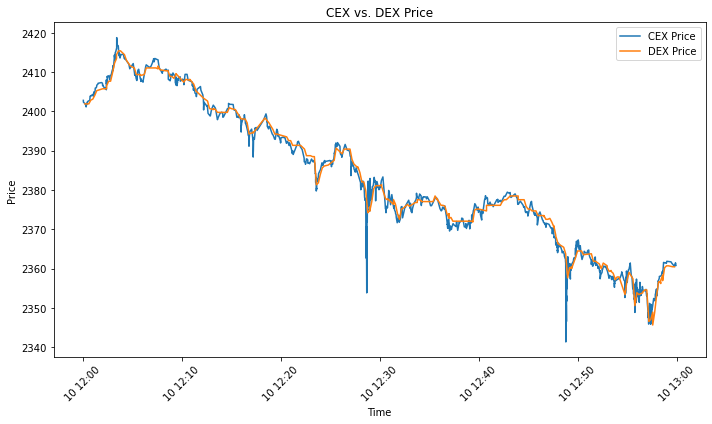

In [5]:
start_time = pd.to_datetime('2024-01-10 12:00:00')
end_time = pd.to_datetime('2024-01-10 12:59:59')
df_cex_f = df_cx[(df_cx['time'] >= start_time) & (df_cx['time'] <= end_time)]
df_dex_f = df_dx[(df_dx['time'] >= start_time) & (df_dx['time'] <= end_time)]

plt.figure(figsize=(10, 6))

plt.plot(df_cex_f['time'], df_cex_f['price'], label='CEX Price')
plt.plot(df_dex_f['time'], df_dex_f['price'], label='DEX Price')

plt.title('CEX vs. DEX Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


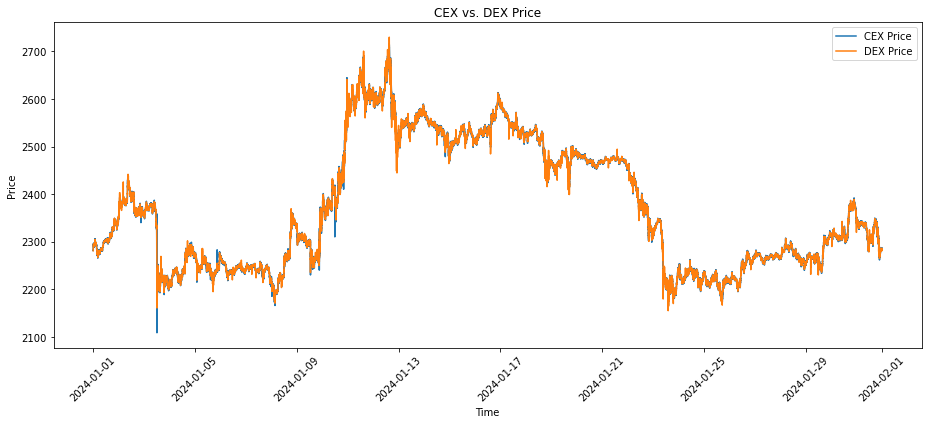

In [6]:
start_time = pd.to_datetime('2024-01-01 00:00:00')
end_time = pd.to_datetime('2024-01-31 23:59:59')
df_cex_f = df_cx[(df_cx['time'] >= start_time) & (df_cx['time'] <= end_time)]
df_dex_f = df_dx[(df_dx['time'] >= start_time) & (df_dx['time'] <= end_time)]

plt.figure(figsize=(13, 6))

plt.plot(df_cex_f['time'], df_cex_f['price'], label='CEX Price')
plt.plot(df_dex_f['time'], df_dex_f['price'], label='DEX Price')

plt.title('CEX vs. DEX Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [7]:
len(df_dx)

188000

# Measuring LVR: arbitrage profits due to stale AMM prices

### Writing all in 1 dataframe for easeness of calculation

In [16]:
df = df_cex_f.copy()
df_dex_f = df_dex_f.sort_values(by='time',ascending=True)
df_dex_f.reset_index(drop=True, inplace = True)
df_dex_f = df_dex_f[df_dex_f['amount0'] != 0]  #eliminating some 0 values
df_dex_f['time_dex'] = df_dex_f['time']

In [23]:
merged_df = pd.merge_asof(df, df_dex_f[['time', 'price', 'time_dex']], on='time', direction='forward', allow_exact_matches=False)
merged_df.rename(columns={'time': 'time_cex', 'price_y': 'price_dex', 'price_x': 'price_cex'}, inplace=True)

In [30]:
merged_df.head(3)

,trade ID,price_cex,qty,base_qty,time_cex,is_buyer_maker,Unnamed: 6,price_dex,time_dex
0,33165689,2281.65,0.0888,202.610520,2024-01-01 00:00:03.953,False,True,2280.878682,2024-01-01 00:00:23
1,33165690,2281.38,0.0060,13.688280,2024-01-01 00:00:12.961,True,True,2280.878682,2024-01-01 00:00:23
2,33165691,2281.19,1.0789,2461.175891,2024-01-01 00:00:12.961,True,True,2280.878682,2024-01-01 00:00:23


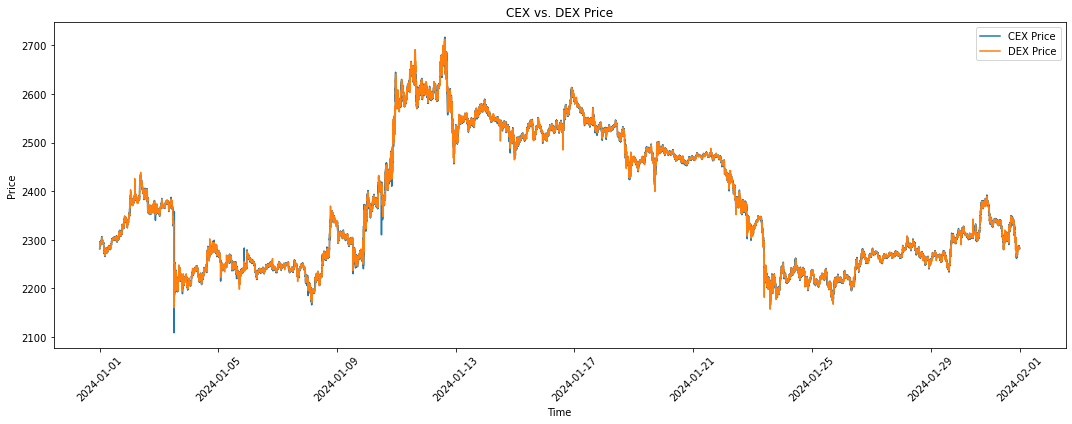

In [27]:
plt.figure(figsize=(15, 6))

plt.plot(merged_df['time_cex'], merged_df['price_cex'], label='CEX Price')
plt.plot(merged_df['time_cex'], merged_df['price_dex'], label='DEX Price')

plt.title('CEX vs. DEX Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [14]:
same_time_as_previous = df_dex_f['time'].eq(df_dex_f['time'].shift(1))
different_price_from_previous = df_dex_f['blockNumber'].ne(df_dex_f['blockNumber'].shift(1))
same_time_different_price = same_time_as_previous & different_price_from_previous
print(f"Number of continuous rows with the same 'time' but different 'blockNumber': {same_time_different_price.sum()}")

Number of continuous rows with the same 'time' but different 'blockNumber': 0


So when we have the same time, there are no repeating blocks, which is good, this means that in one specific second, there were no more than 1 block pushed

In [11]:
df_grouped = df_dex_f.groupby('time').agg({'amount0': 'sum', 'amount1': 'sum'}).reset_index()

merged_df = pd.merge(merged_df, df_grouped, left_on='time_dex', right_on='time', how='left')
merged_df.rename(columns={'amount0': 'sum_amount0', 'amount1': 'sum_amount1'}, inplace=True)
merged_df.drop('time_y', axis=1, inplace=True)

In [18]:
merged_df.head(20)

,trade ID,price_x,qty,base_qty,time_x,is_buyer_maker,Unnamed: 6,price_dex,time_dex,sum_amount0,sum_amount1
0,33165689,2281.65,0.0888,202.610520,2024-01-01 00:00:03.953,False,True,2280.878682,2024-01-31 11:34:47,-1.232390e+06,539.283224
1,33165690,2281.38,0.0060,13.688280,2024-01-01 00:00:12.961,True,True,2280.878682,2024-01-31 11:34:47,-1.232390e+06,539.283224
2,33165691,2281.19,1.0789,2461.175891,2024-01-01 00:00:12.961,True,True,2280.878682,2024-01-31 11:34:47,-1.232390e+06,539.283224
3,33165692,2281.19,0.1851,422.248269,2024-01-01 00:00:12.962,True,True,2280.878682,2024-01-31 11:34:47,-1.232390e+06,539.283224
4,33165693,2281.19,0.5748,1311.228012,2024-01-01 00:00:12.962,True,True,2280.878682,2024-01-31 11:34:47,-1.232390e+06,539.283224
5,33165694,2281.08,0.0888,202.559904,2024-01-01 00:00:30.080,False,True,2281.106770,2024-01-31 22:39:11,1.094950e+05,-47.986064
6,33165695,2282.69,0.0153,34.925157,2024-01-01 00:00:35.850,False,True,2281.106770,2024-01-31 22:39:11,1.094950e+05,-47.986064
7,33165696,2281.64,0.0888,202.609632,2024-01-01 00:01:08.214,False,True,2281.106770,2024-01-31 22:39:11,1.094950e+05,-47.986064
8,33165697,2282.29,0.0888,202.667352,2024-01-01 00:01:34.026,False,True,2282.019350,2024-01-31 23:56:11,-4.516198e+04,19.800000
9,33165698,2282.69,0.3452,787.984588,2024-01-01 00:01:36.392,False,True,2282.019350,2024-01-31 23:56:11,-4.516198e+04,19.800000


### Now we do the second type of merge

In [32]:
df['time_cex'] = df['time']

In [43]:
merged_df2 = pd.merge_asof(df_dex_f, df[['time', 'price', 'time_cex']], on='time', direction='backward', allow_exact_matches=False)
merged_df2.rename(columns={'price_x': 'price_dex', 'price_y': 'price_cex'}, inplace=True)

In [46]:
merged_df2.head(5)

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,blockNumber,symbol0,symbol1,price_dex,tcost_usd,time,time_dex,price_cex,time_cex
0,18096.796543,-7.930474,18076.269412,0xe743a49f04f2f77eb2d3b753ae3ad599de8cea84,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x4fd39c9e151e50580779bd04b1f7ecc310079fd3,1.704067e+09,427523,1.358341e+10,1.358341e-08,18908896,USDC,WETH,2280.878682,13.245562,2024-01-01 00:00:23,2024-01-01 00:00:23,2281.19,2024-01-01 00:00:12.962
1,700.000000,-0.306764,699.212694,0xa1179a0b94e53ee82b77c6d24c2cf67a656c2503,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704067e+09,312000,1.438341e+10,1.438341e-08,18908896,USDC,WETH,2280.878682,10.235724,2024-01-01 00:00:23,2024-01-01 00:00:23,2281.19,2024-01-01 00:00:12.962
2,25000.000000,-10.955150,24971.093893,0x9b4306e7b6ede125b5e8cac309ffb58af5eed6f0,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,223193,1.259051e+10,1.259051e-08,18908898,USDC,WETH,2281.106770,6.410172,2024-01-01 00:00:47,2024-01-01 00:00:47,2282.69,2024-01-01 00:00:35.850
3,767.722283,-0.336412,766.824534,0xc10527cdbc055b7f9a8a4ad765b287190c861c51,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,247124,1.230578e+10,1.230578e-08,18908899,USDC,WETH,2281.106770,6.936970,2024-01-01 00:00:59,2024-01-01 00:00:59,2282.69,2024-01-01 00:00:35.850
4,170.905965,-0.074890,170.706032,0xf468072ca8f81e11655c252a37317e814b24872b,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0xa9cffe466ba8a72707d1104de239c9ab477e2493,1.704067e+09,2673946,1.443436e+10,1.443436e-08,18908901,USDC,WETH,2281.106770,88.043187,2024-01-01 00:01:23,2024-01-01 00:01:23,2281.64,2024-01-01 00:01:08.214


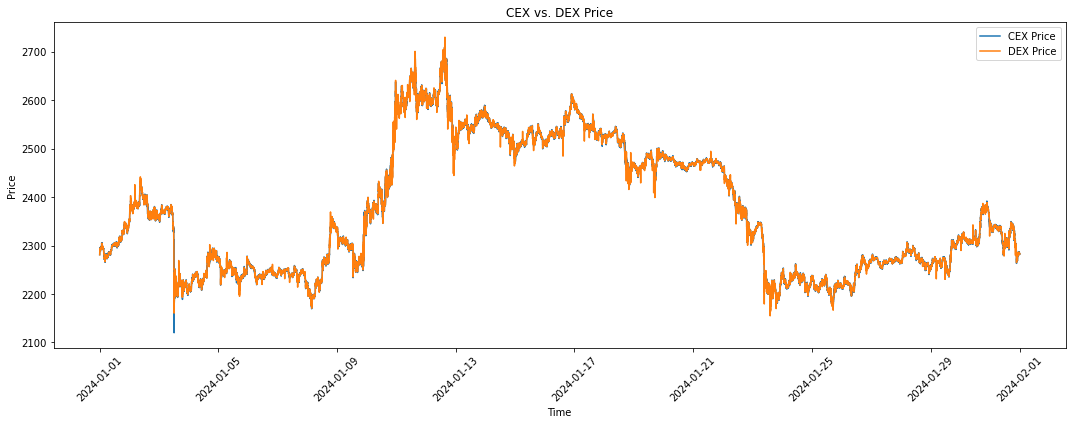

In [47]:
plt.figure(figsize=(15, 6))

plt.plot(merged_df2['time_cex'], merged_df2['price_cex'], label='CEX Price')
plt.plot(merged_df2['time_cex'], merged_df2['price_dex'], label='DEX Price')

plt.title('CEX vs. DEX Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [50]:
# This is the price difference
merged_df2['LVR_clean'] = merged_df2['price_cex'] - merged_df2['price_dex']
merged_df2['LVR_clean_cumm'] = merged_df2['LVR_clean'].abs().cumsum()
merged_df2.head(3)

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,symbol0,symbol1,price_dex,tcost_usd,time,time_dex,price_cex,time_cex,LVR_clean,LVR_clean_cumm
0,18096.796543,-7.930474,18076.269412,0xe743a49f04f2f77eb2d3b753ae3ad599de8cea84,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x4fd39c9e151e50580779bd04b1f7ecc310079fd3,1.704067e+09,427523,1.358341e+10,1.358341e-08,...,USDC,WETH,2280.878682,13.245562,2024-01-01 00:00:23,2024-01-01 00:00:23,2281.19,2024-01-01 00:00:12.962,0.311318,0.311318
1,700.000000,-0.306764,699.212694,0xa1179a0b94e53ee82b77c6d24c2cf67a656c2503,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704067e+09,312000,1.438341e+10,1.438341e-08,...,USDC,WETH,2280.878682,10.235724,2024-01-01 00:00:23,2024-01-01 00:00:23,2281.19,2024-01-01 00:00:12.962,0.311318,0.622636
2,25000.000000,-10.955150,24971.093893,0x9b4306e7b6ede125b5e8cac309ffb58af5eed6f0,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,223193,1.259051e+10,1.259051e-08,...,USDC,WETH,2281.106770,6.410172,2024-01-01 00:00:47,2024-01-01 00:00:47,2282.69,2024-01-01 00:00:35.850,1.583230,2.205866


In [51]:
print('Total amount of USD provided to the pool by traders:', df_dex_f.amount0.sum())
print('Total amount of ETH provided to the pool by traders:', df_dex_f.amount1.sum())

Total amount of USD provided to the pool by traders: -29416389.356762014
Total amount of ETH provided to the pool by traders: 13596.387163926185


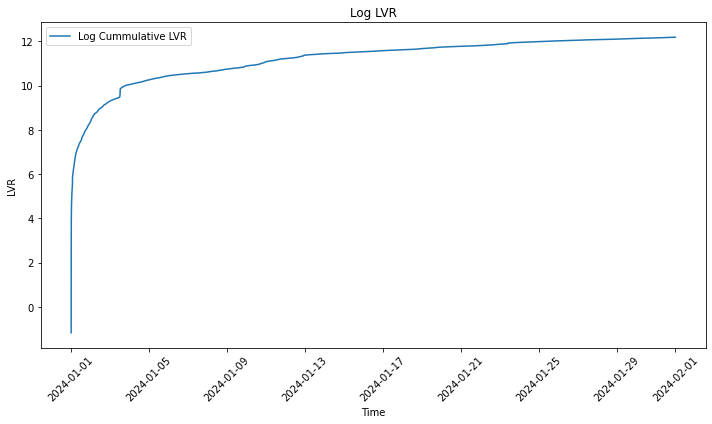

In [53]:
plt.figure(figsize=(10, 6))

plt.plot(merged_df2['time_dex'], np.log(merged_df2['LVR_clean_cumm']), label='Log Cummulative LVR')

plt.title('Log LVR')
plt.xlabel('Time')
plt.ylabel('LVR')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Positive amount0 or amount1: This means that the quantity of the token represented by the respective amount field was added to the liquidity pool. This is the amount of the token that the liquidity pool received.d.

In [55]:
#This is the difference in price times the amount transacted
merged_df2['LVR'] = merged_df2['amount1']*merged_df2['LVR_clean']
merged_df2['LVR_cumm'] = merged_df2['LVR'].abs().cumsum()
merged_df2.head(3)

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,price_dex,tcost_usd,time,time_dex,price_cex,time_cex,LVR_clean,LVR_clean_cumm,LVR,LVR_cumm
0,18096.796543,-7.930474,18076.269412,0xe743a49f04f2f77eb2d3b753ae3ad599de8cea84,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x4fd39c9e151e50580779bd04b1f7ecc310079fd3,1.704067e+09,427523,1.358341e+10,1.358341e-08,...,2280.878682,13.245562,2024-01-01 00:00:23,2024-01-01 00:00:23,2281.19,2024-01-01 00:00:12.962,0.311318,0.311318,-2.468898,2.468898
1,700.000000,-0.306764,699.212694,0xa1179a0b94e53ee82b77c6d24c2cf67a656c2503,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704067e+09,312000,1.438341e+10,1.438341e-08,...,2280.878682,10.235724,2024-01-01 00:00:23,2024-01-01 00:00:23,2281.19,2024-01-01 00:00:12.962,0.311318,0.622636,-0.095501,2.564399
2,25000.000000,-10.955150,24971.093893,0x9b4306e7b6ede125b5e8cac309ffb58af5eed6f0,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,223193,1.259051e+10,1.259051e-08,...,2281.106770,6.410172,2024-01-01 00:00:47,2024-01-01 00:00:47,2282.69,2024-01-01 00:00:35.850,1.583230,2.205866,-17.344522,19.908921


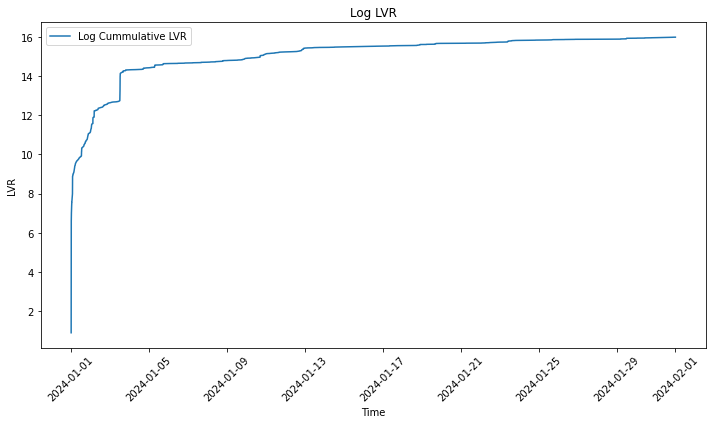

In [56]:
plt.figure(figsize=(10, 6))

plt.plot(merged_df2['time_dex'], np.log(merged_df2['LVR_cumm']), label='Log Cummulative LVR')

plt.title('Log LVR')
plt.xlabel('Time')
plt.ylabel('LVR')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [65]:
merged_df2[0:60000].to_pickle("Merged_CEX_DEX_v2_p1.pkl")
merged_df2[60000:120000].to_pickle("Merged_CEX_DEX_v2_p2.pkl")
merged_df2[120000::].to_pickle("Merged_CEX_DEX_v2_p3.pkl")

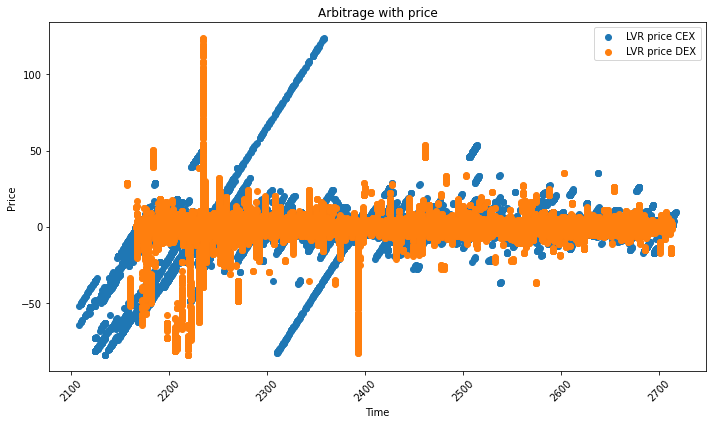

In [23]:
plt.figure(figsize=(10, 6))

plt.scatter(merged_df['price_x'], merged_df['LVR'], label='LVR price CEX')
plt.scatter(merged_df['price_dex'], merged_df['LVR'], label='LVR price DEX')

plt.title('Arbitrage with price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()